# CMS ex situ GIWAXS 2023C3

# CMS GIWAXS raw data processing & exporting notebook
In this notebook you output xr.DataSets stored as .zarr stores containing all your raw,
remeshed (reciprocal space), and caked CMS GIWAXS data. Saving as a zarr automatically converts the array to a dask array

In [ ]:
### Kernel updates if needed, remember to restart kernel after running this cell!:
!pip install -e /nsls2/users/alevin/repos/PyHyperScattering  # to use pip to install via directory

## Imports

In [ ]:
### Imports:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import xarray as xr
import PyHyperScattering as phs
import pygix
import gc
from tqdm.auto import tqdm  # progress bar loader!

print(f'Using PyHyperScattering Version: {phs.__version__}')

## Defining some objects

### Define & check paths

In [83]:
pix_size = 0.000172
673 * pix_size

0.115756

In [69]:
maskponiPath

PosixPath('/nsls2/data/cms/proposals/2023-3/pass-311415/AL_processed_data/maskponi')

In [84]:
# I like pathlib for its readability & checkability, it's also necessary for the loadSeries function later on
# Replace the paths with the ones relevant to your data, you can use the ".exists()" method to make sure you defined a path correctly
userPath = pathlib.Path('/nsls2/users/alevin')
propPath = pathlib.Path('/nsls2/data/cms/proposals/2023-3/pass-311415')
dataPath = propPath.joinpath('AL_processed_data/KWhite2/waxs')
rawPath = dataPath.joinpath('raw')
samplesPath = dataPath.joinpath('stitched')
calibPath = rawPath.joinpath('AgBH_cali_5m_12.7kev_x0.000_th0.000_10.00s_1307208_waxs.tiff')
maskponiPath = propPath.joinpath('AL_processed_data/maskponi')  # place for pyhyper-drawn masks and poni files

outPath = propPath.joinpath('AL_processed_data')

# Select poni & mask filepaths
poniFile = maskponiPath.joinpath('CeO2_2023-12-03_y673_x464p3.poni')
# maskFile = maskponiPath.joinpath('blank.json')
maskFile = maskponiPath.joinpath('pilatus1m_vertical_gaps_only.json')

# Create pg Transform objects with the above information:
# Can set the energy to overwrite default poni energy, this MUST be correct for your samples!
pg_transformer = phs.GIWAXS.Transform(poniPath=poniFile, maskPath=None, energy=12.7)

# Colormap
cmap = plt.cm.turbo
cmap.set_bad('black')

In [85]:
def poni_centers(poniFile, pix_size=0.000172):
    """
    Returns poni center value and the corresponding pixel position. Default pixel size is 172 microns (Pilatus 1M)
    
    Inputs: poniFile as pathlib path object to the poni file
    Outputs: ((poni1, y_center), (poni2, x_center))
    """
    
    with poniFile.open('r') as f:
        lines = list(f.readlines())
    poni1_str = lines[6]
    poni2_str = lines[7]

    poni1 = float(poni1_str.split(' ')[1])
    poni2 = float(poni2_str.split(' ')[1])

    y_center = poni1 / pix_size
    x_center = poni2 / pix_size
        
    return ((poni1, y_center), (poni2, x_center))

poni_centers(poniFile)

((0.115756, 673.0), (0.07986737544963479, 464.34520610252787))

### Define metadata naming scheme & initialize loaders

In [ ]:
[f.name for f in sorted(samplesPath.glob('*pos1*'))]

In [ ]:
[len(f.name.split('_')) for f in sorted(samplesPath.glob('*pos1*'))]

In [ ]:
[f.name for f in sorted(samplesPath.glob('*pos1*')) if len(f.name.split('_'))==9]

In [86]:
fixed_rpm_set = [f for f in sorted(samplesPath.glob('*')) if len(f.name.split('_'))==9]
variable_rpm_set = [f for f in sorted(samplesPath.glob('*')) if len(f.name.split('_'))==10]

In [87]:
len(fixed_rpm_set)

112

In [88]:
len(variable_rpm_set)

64

In [89]:
# set ex situ metadata filename naming schemes:
fixed_rpm_md_naming_scheme =    ['project', 'material', 'solvent', 'detector_pos', 'sample_pos', 
                                 'incident_angle', 'exposure_time', 'scan_id', 'detector']
variable_rpm_md_naming_scheme = ['project', 'material', 'solvent', 'rpm', 'detector_pos', 'sample_pos', 
                                 'incident_angle', 'exposure_time', 'scan_id', 'detector']

# Initalize CMSGIWAXSLoader objects with the above naming schemes
fixed_rpm_loader = phs.load.CMSGIWAXSLoader(md_naming_scheme=fixed_rpm_md_naming_scheme)
variable_rpm_loader = phs.load.CMSGIWAXSLoader(md_naming_scheme=variable_rpm_md_naming_scheme)

## Data processing
Break this section up however makes sense for your data

In [90]:
loader = phs.load.CMSGIWAXSLoader()
# calibPath = pathlib.Path('/nsls2/data/cms/proposals/2023-2/pass-311415/KWhite5/maxs/raw/LaB6_5.6m_12.7keV_4250.1s_x0.001_th0.120_10.00s_1118442_maxs.tiff')
calib_DA = loader.loadSingleImage(calibPath)  # Loads the file specified at calibPath into an xr.DataArray object

In [98]:
savePath = outPath.joinpath('zarrs/bcy673')

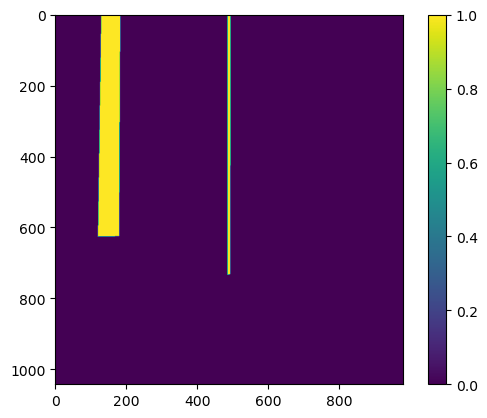

In [92]:
# Load a mask as np.array (can use any method)
draw = phs.IntegrationUtils.DrawMask(calib_DA)
draw.load(maskFile)

mask = draw.mask  # Loads mask as numpy array

# Show np.array mask:
plt.imshow(mask)
plt.colorbar()

# Initialize a transformer:
transformer = phs.GIWAXS.Transform(poniPath=poniFile, maskPath=maskFile, energy=12.7)
# transformer = phs.GIWAXS.Transform(poniPath=poniFile, maskPath=mask, energy=12.7)

In [93]:
fixed_raw_DS, fixed_recip_DS, fixed_caked_DS = phs.GIWAXS.single_images_to_dataset(fixed_rpm_set, fixed_rpm_loader, transformer) 

Transforming Raw Data:   0%|          | 0/111 [00:00<?, ?it/s]

No save path or no filename specified, not saving zarrs... 


#### Yoneda check:

In [188]:
yoneda_angles

array([0.19, 0.21, 0.23, 0.25])

In [ ]:
qz_inv_meters = ((4 * np.pi) / (wavelength)) * (np.sin(np.deg2rad(angles)))
qz_inv_angstroms = qz_inv_meters / 1e10

In [200]:
def qz(wavelength, alpha_crit, alpha_incidents):
    qz_inv_meters = ((4 * np.pi) / (wavelength)) * (np.sin(np.deg2rad((alpha_incidents + alpha_crit)/2)))
    # qz_inv_meters = ((4 * np.pi) / (wavelength)) * (np.sin(np.deg2rad(alpha_crit)) + np.sin(np.deg2rad(alpha_incidents)))
    qz_inv_angstroms = qz_inv_meters / 1e10
    return qz_inv_angstroms


wavelength = 9.762535309700809e-11  # 12.7 keV

alpha_crit = 0.11  # organic film critical angle
alpha_incidents = np.array([0.08, 0.1, 0.12, 0.14])

yoneda_angles = alpha_incidents + alpha_crit

qz(wavelength, alpha_crit, alpha_incidents)

array([0.02134263, 0.02358922, 0.02583581, 0.0280824 ])

In [94]:
def select_attrs(data_arrays_iterable, selected_attrs_dict):
    """
    Selects data arrays whose attributes match the specified values.

    Parameters:
    data_arrays_iterable: Iterable of xarray.DataArray objects.
    selected_attrs_dict: Dictionary where keys are attribute names and 
                         values are the attributes' desired values.

    Returns:
    List of xarray.DataArray objects that match the specified attributes.
    """    
    sublist = list(data_arrays_iterable)
    
    for attr_name, attr_values in selected_attrs_dict.items():
        sublist = [da for da in sublist if da.attrs[attr_name] in attr_values]
                
    return sublist

  0%|          | 0/4 [00:00<?, ?it/s]

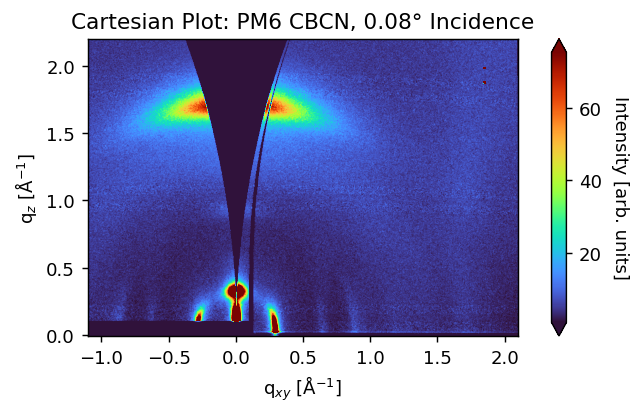

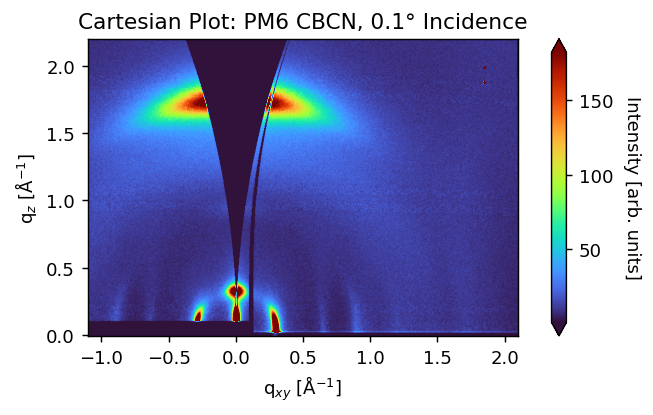

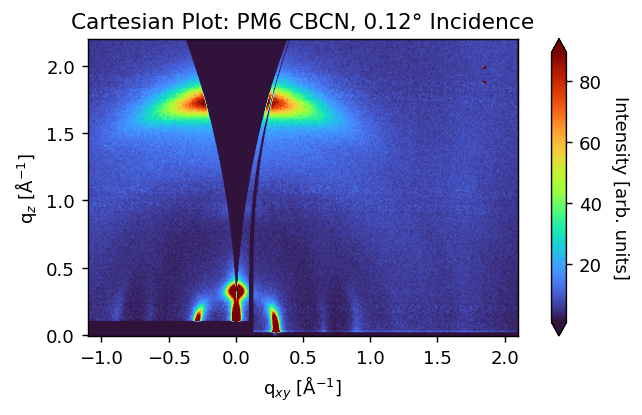

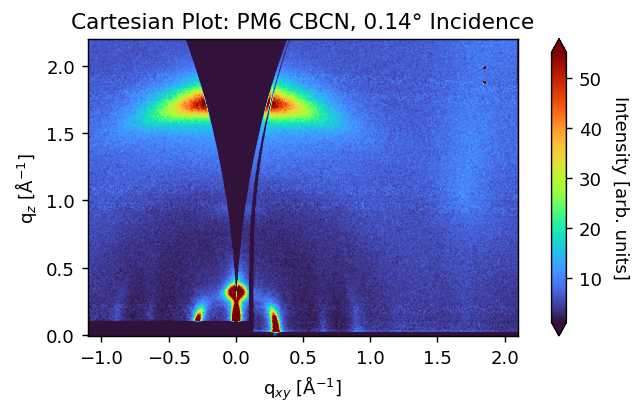

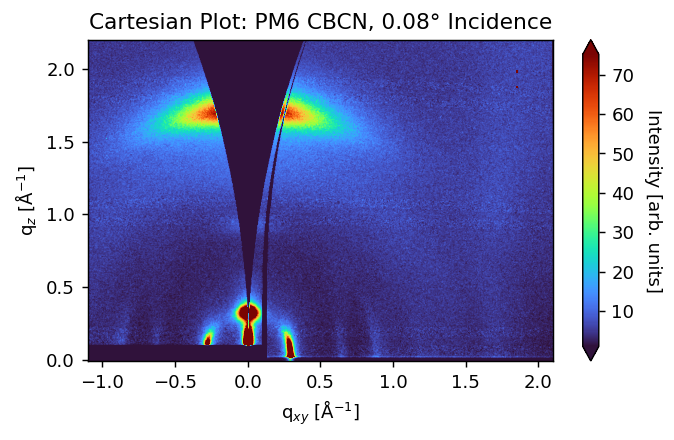

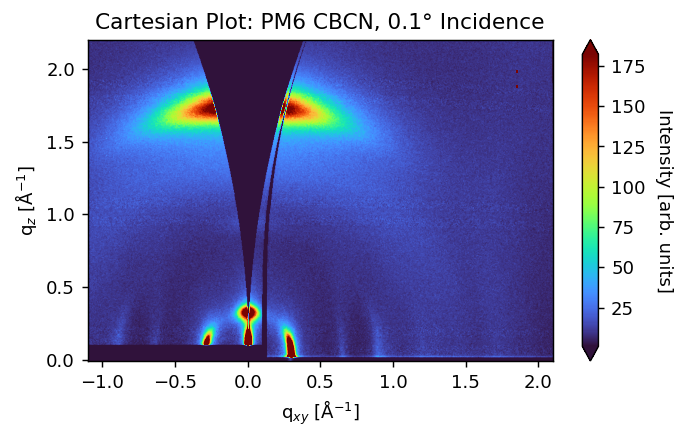

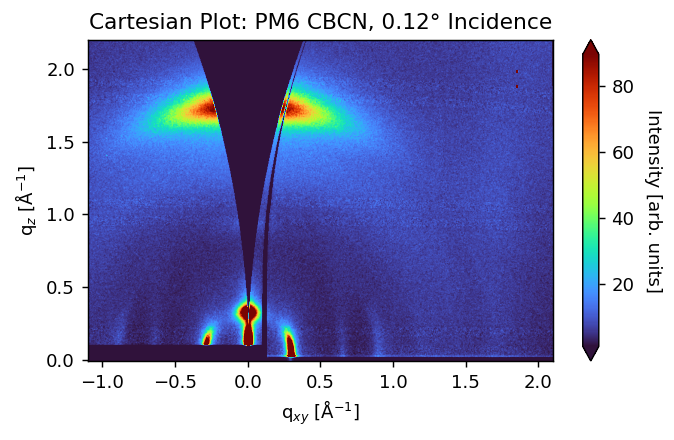

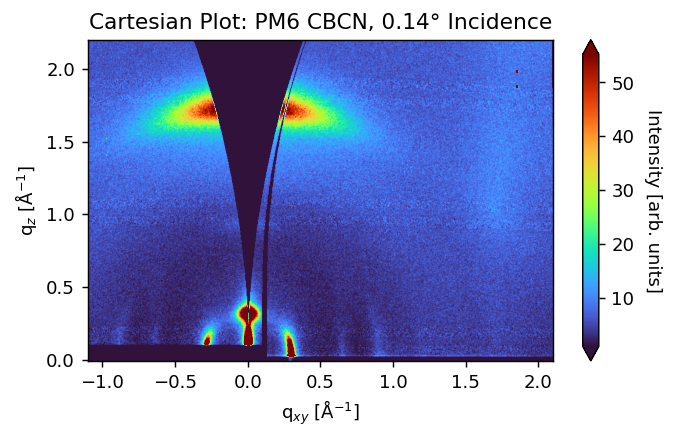

In [110]:
# 2D reciprocal space cartesian plots
qxy_min = -1.1
qxy_max = 2.1
qz_min = -0.01
qz_max = 2.2

selected_attrs_dict = {'material': ['PM6'], 'solvent': ['CBCN']}
# selected_attrs_dict = {}

selected_DAs = select_attrs(fixed_recip_DS.data_vars.values(), selected_attrs_dict)
for DA in tqdm(selected_DAs):
    # Slice data for selected q ranges (will need to rename q_xy if dimensions are differently named)
    sliced_DA = DA.sel(q_xy=slice(qxy_min, qxy_max), q_z=slice(qz_min, qz_max))
    
    real_min = float(sliced_DA.compute().quantile(0.05))
    cmin = 1 if real_min < 1 else real_min

    cmax = float(sliced_DA.compute().quantile(0.997))   
    
    # Plot
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=plt.Normalize(cmin, cmax), interpolation='antialiased', figsize=(5.5,3.3))
    ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=15)
    # ax.axes.set(aspect='equal', title=f'Cartesian Plot: {DA.material} {DA.solvent} {DA.rpm}, {float(DA.incident_angle[2:])}° Incidence',
    #             xlabel='q$_{xy}$ [Å$^{-1}$]', ylabel='q$_z$ [Å$^{-1}$]')
    ax.axes.set(aspect='equal', title=f'Cartesian Plot: {DA.material} {DA.solvent}, {float(DA.incident_angle[2:])}° Incidence',
                xlabel='q$_{xy}$ [Å$^{-1}$]', ylabel='q$_z$ [Å$^{-1}$]')
    ax.figure.set(tight_layout=True, dpi=130)
    
    # ax.figure.savefig(savePath.joinpath(f'{DA.material}-{DA.solvent}-{DA.rpm}_qxy{qxy_min}to{qxy_max}_qz{qz_min}to{qz_max}_{DA.incident_angle}.png'), dpi=150)
    # ax.figure.savefig(savePath.joinpath(f'{DA.material}-{DA.solvent}_qxy{qxy_min}to{qxy_max}_qz{qz_min}to{qz_max}_{DA.incident_angle}.png'), dpi=150)

    plt.show()
    plt.close('all')

  0%|          | 0/4 [00:00<?, ?it/s]

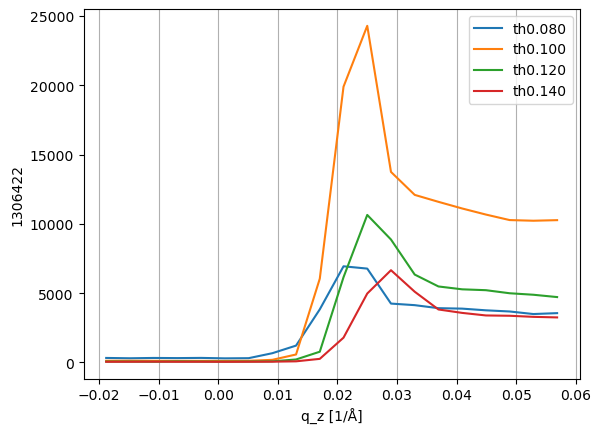

In [96]:
# Yoneda peak linecut check
qxy_min = 0.22
qxy_max = 2
qz_min = -0.02
qz_max = 0.06

selected_DAs = select_attrs(fixed_recip_DS.data_vars.values(), selected_attrs_dict)
for DA in tqdm(selected_DAs):
    # Slice data for selected q ranges (will need to rename q_xy if dimensions are differently named)
    sliced_DA = DA.sel(q_xy=slice(qxy_min, qxy_max), q_z=slice(qz_min, qz_max))
    qz_integrated_DA = sliced_DA.sum('q_xy')
    
    # Plot
    qz_integrated_DA.plot.line(label=DA.incident_angle)
    
plt.legend()
plt.grid(visible=True, which='major', axis='x')
plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

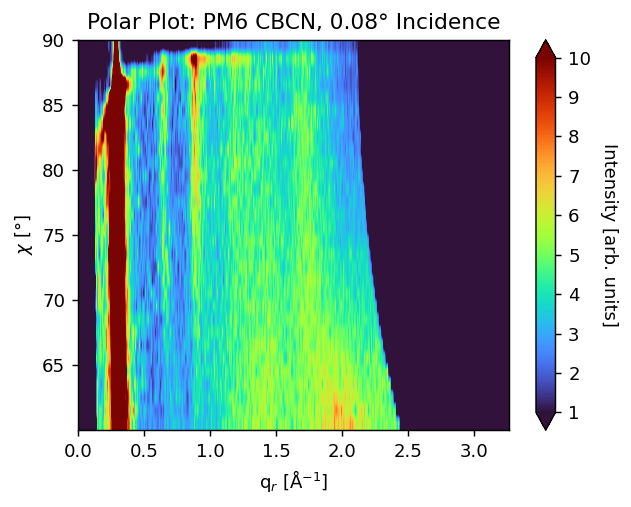

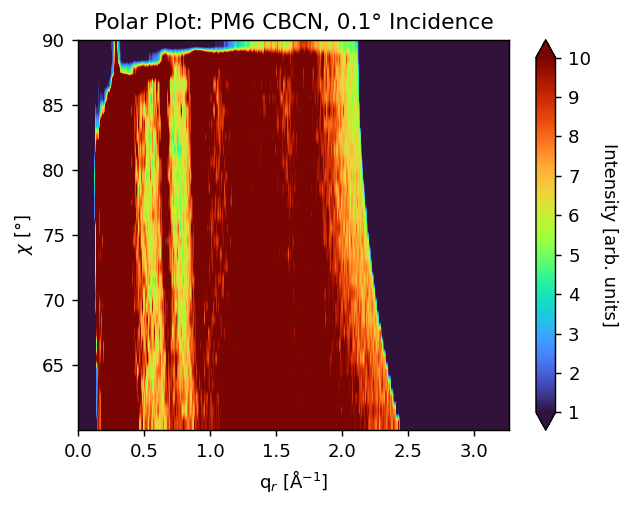

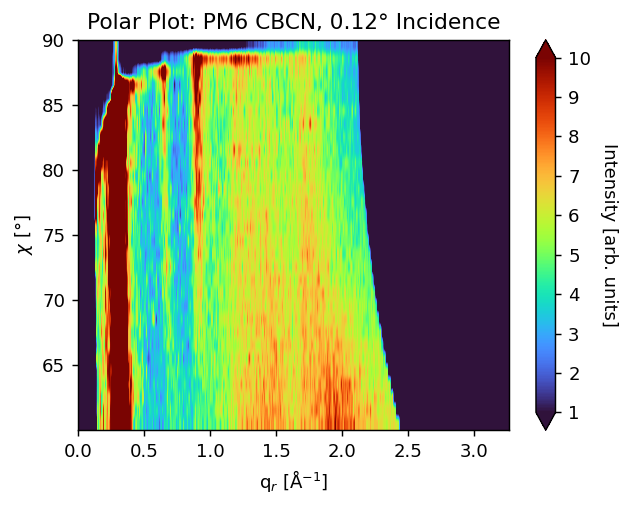

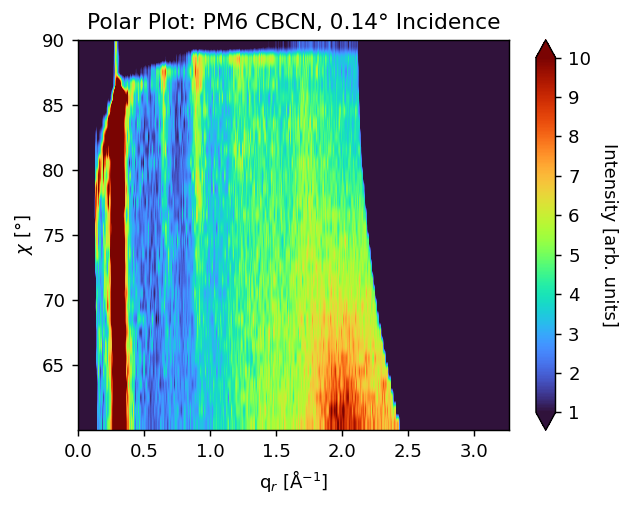

In [97]:
chi_min = 60
chi_max = None

selected_DAs = select_attrs(fixed_caked_DS.data_vars.values(), selected_attrs_dict)
for DA in tqdm(selected_DAs):
    # Slice dataarray to select plotting region 
    sliced_DA = DA.sel(chi=slice(chi_min,chi_max))
    
    # real_min = float(DA.sel(q_xy=slice(-0.5, -0.1), q_z=slice(0.1, 0.4)).compute().quantile(1e-3))
    real_min = float(DA.compute().quantile(0.05))
    cmin = 1 if real_min < 1 else real_min
    
    # cmax = float(DA.sel(q_xy=slice(-0.5, -0.1), q_z=slice(0.1, 2)).compute().quantile(1))   
    cmax = float(DA.compute().quantile(0.999))  
    
    # Plot sliced dataarray
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=plt.Normalize(cmin, 10), figsize=(5,4), interpolation='antialiased')  # plot, optional parameter interpolation='antialiased' for image smoothing
    ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=15)  # set colorbar label & parameters 
    ax.axes.set(title=f'Polar Plot: {DA.material} {DA.solvent}, {float(DA.incident_angle[2:])}° Incidence',
                xlabel='q$_r$ [Å$^{-1}$]', ylabel='$\chi$ [°]')  # set title, axis labels, misc
    ax.figure.set(tight_layout=True, dpi=130)  # Adjust figure dpi & plotting style
    
    plt.show()  # Comment to mute plotting output
    
    # Uncomment below line and set savepath/savename for saving plots, I usually like to check 
    # ax.figure.savefig(outPath.joinpath('PM6-Y6set_waxs', f'polar-2D_{DA.sample_id}_{chi_min}to{chi_max}chi_{DA.incident_angle}.png'), dpi=150)
    plt.close('all')

In [99]:
fixed_recip_DS.to_zarr(savePath.joinpath('fix_recip_stitched.zarr'), mode='w')

In [100]:
fixed_raw_DS.to_zarr(savePath.joinpath('fix_raw_stitched.zarr'), mode='w')

In [101]:
fixed_caked_DS.to_zarr(savePath.joinpath('fix_caked_stitched.zarr'), mode='w')

In [102]:
variable_raw_DS, variable_recip_DS, variable_caked_DS = phs.GIWAXS.single_images_to_dataset(variable_rpm_set, variable_rpm_loader, transformer)

Transforming Raw Data:   0%|          | 0/63 [00:00<?, ?it/s]

No save path or no filename specified, not saving zarrs... 


In [103]:
variable_recip_DS.to_zarr(savePath.joinpath('var_recip_stitched.zarr'), mode='w')

In [104]:
variable_raw_DS.to_zarr(savePath.joinpath('var_raw_stitched.zarr'), mode='w')

In [105]:
variable_caked_DS.to_zarr(savePath.joinpath('var_caked_stitched.zarr'), mode='w')